In [164]:
from pathlib import Path
import pandas as pd
from datetime import timedelta
import requests
import yfinance as yf
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
#from xgboost import XGBClassifier
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix

In [165]:
#read csv data from IPO Scoop into a dataframe and set the company Symbol as the index
#other columns include industry type, amount of shares in millions, initial offer price, closing on the first day
#current price and returns, and then dropping the 1st day close column
ipo_csv = pd.read_csv('IpoScoop2018+.csv')
filtered_ipo=ipo_csv.drop(columns=["1st Day Close"])
filtered_ipo.set_index('Symbol',inplace=True)

<AxesSubplot:ylabel='Industry'>

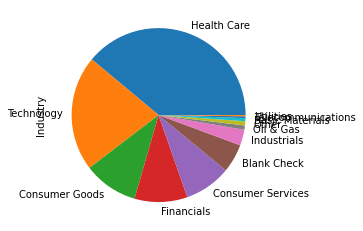

In [166]:
#visualization of different industries
sector_count = filtered_ipo["Industry"].value_counts()
sector_count.plot(kind="pie")

In [167]:
filtered_ipo["Offer Date"]=pd.to_datetime(filtered_ipo["Offer Date"], infer_datetime_format=True)
filter_ipo = filtered_ipo.drop(['MTAL.U', 'TPGS', 'KVSB', 'STRE.U', 'SCR', 'FWAA', 'HCAQ', 'TBA.U', 'HFEN', 'FSDC', 'ARYA', 'PAND', 'TXAC', 'HECCU', 'CSPR', 'PPD', 'DNK', 'VIE', 'HKIB', 'WSG', 'LVGO', 'PROS', 'MDLA', 'PRVL', 'PRVL', 'PRVL', 'MWK', 'GSX', 'RUHN', 'FHL'])
filter_ipo

,Company,Industry,Offer Date,Shares (millions),Offer Price,Current Price,Return
Symbol,,,,,,,
BLTE,"Belite Bio, Inc.",Health Care,2022-04-29,6.0,$6.00,$10.59,76.50%
HLVX,"HilleVax, Inc.",Health Care,2022-04-29,11.8,$17.00,$19.09,12.29%
OST,"Ostin Technology Group Co., Ltd.",Industrials,2022-04-27,3.4,$4.00,$3.70,-7.50%
TNON,"Tenon Medical, Inc.",Health Care,2022-04-27,3.2,$5.00,$21.61,332.20%
JCSE,JE Cleantech Holdings Limited,Industrials,2022-04-22,3.8,$4.00,$4.35,8.75%
...,...,...,...,...,...,...,...
TLRY,Tilray,Health Care,2018-07-19,9.0,$17.00,$46.56,173.88%
CCB,Coastal Financial,Financials,2018-07-18,2.9,$14.50,$15.47,6.69%
CRNX,Crinetics Pharmaceuticals,Health Care,2018-07-18,6.0,$17.00,$25.00,47.06%


In [168]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
ten_days = pd.to_timedelta(10,'days')
three_months = pd.to_timedelta(84,'days')
hundred_days = pd.to_timedelta(100,'days')
filter_ipo['T-10Days'] = filter_ipo['Offer Date']-ten_days
filter_ipo['T-90Days'] = filter_ipo['Offer Date']-three_months
filter_ipo['T+100Days'] = filter_ipo['Offer Date']+hundred_days

In [169]:
#convert to string for yf useage
filter_ipo['T-10Days'] = filter_ipo['T-10Days'].astype(str)
filter_ipo['T-90Days'] = filter_ipo['T-90Days'].astype(str)
filter_ipo['T+100Days'] = filter_ipo['T+100Days'].astype(str)

In [170]:
spy_returns_ALL = yf.download("SPY","2018-06-01")
spy_returns_ALL

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-06-01,272.410004,273.940002,272.329987,273.600006,258.023407,71258400
2018-06-04,274.529999,275.190002,274.260010,274.899994,259.249390,45385200
2018-06-05,275.049988,275.529999,274.179993,275.100006,259.437958,51135000
2018-06-06,275.790009,277.519989,275.089996,277.399994,261.607086,62732200
2018-06-07,277.950012,278.279999,276.339996,277.369995,261.578705,72969400
...,...,...,...,...,...,...
2022-04-25,423.670013,428.690002,418.839996,428.510010,428.510010,119647700
2022-04-26,425.829987,426.040009,416.070007,416.100006,416.100006,103996300
2022-04-27,417.239990,422.920013,415.010010,417.269989,417.269989,122030000


In [171]:
test_spy_1 = spy_returns_ALL.loc[filter_ipo.loc["BLTE",'T-90Days']: filter_ipo.loc["BLTE",'T-10Days']]


In [172]:
test_spy_1.iloc[0]

Open         4.463500e+02
High         4.527800e+02
Low          4.438300e+02
Close        4.487000e+02
Adj Close    4.487000e+02
Volume       1.184544e+08
Name: 2022-02-04 00:00:00, dtype: float64

In [173]:
test_spy_2.iloc[0]

Open         4.463500e+02
High         4.527800e+02
Low          4.438300e+02
Close        4.487000e+02
Adj Close    4.487000e+02
Volume       1.184544e+08
Name: 2022-02-04 00:00:00, dtype: float64

In [174]:
test_spy_2 = yf.download("SPY",filter_ipo.loc["BLTE",'T-90Days'], filter_ipo.loc["BLTE",'T-10Days'],progress=True)

[*********************100%***********************]  1 of 1 completed


In [175]:
test_spy_2

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-02-04,446.350006,452.779999,443.829987,448.700012,448.700012,118454400
2022-02-07,449.510010,450.989990,445.850006,447.260010,447.260010,84472900
2022-02-08,446.730011,451.920013,445.220001,450.940002,450.940002,81012000
2022-02-09,455.220001,457.880005,455.010010,457.540009,457.540009,92589900
2022-02-10,451.339996,457.709991,447.200012,449.320007,449.320007,140103700
2022-02-11,449.410004,451.609985,438.940002,440.459991,440.459991,153214600
2022-02-14,439.920013,441.600006,435.339996,439.019989,439.019989,123006300
2022-02-15,443.730011,446.279999,443.179993,446.100006,446.100006,88482700
2022-02-16,443.929993,448.059998,441.940002,446.600006,446.600006,84863600


In [176]:
filter_ipo2 = filter_ipo.copy()

In [177]:
for ticker in filter_ipo2.index:
    data3 = spy_returns_ALL.loc[filter_ipo2.loc[ticker,'T-90Days']:filter_ipo2.loc[ticker,'T-10Days']]# [start: end] dates
    spy_return = (data3.iloc[-1,-2] - data3.iloc[0,-2])/data3.iloc[0,-2]
    filter_ipo2.loc[ticker,'SPY 90D Return'] = spy_return
    print(ticker)
    data2=yf.download(ticker,filter_ipo2.loc[ticker,'Offer Date'], filter_ipo2.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo2.loc[ticker,'100 day Return'] = stock_return

BLTE
[*********************100%***********************]  1 of 1 completed
HLVX
[*********************100%***********************]  1 of 1 completed
OST
[*********************100%***********************]  1 of 1 completed
TNON
[*********************100%***********************]  1 of 1 completed
JCSE
[*********************100%***********************]  1 of 1 completed
APLD
[*********************100%***********************]  1 of 1 completed
EE
[*********************100%***********************]  1 of 1 completed
GNS
[*********************100%***********************]  1 of 1 completed
XPON
[*********************100%***********************]  1 of 1 completed
ANTX
[*********************100%***********************]  1 of 1 completed
AKAN
[*********************100%***********************]  1 of 1 completed
MGLD
[*********************100%***********************]  1 of 1 completed
BWV
[*********************100%***********************]  1 of 1 completed
MHUA
[*********************100%************

IndexError: single positional indexer is out-of-bounds

In [ ]:
#make copies of the ipo dataframe with times showing 10 days before, 84 days before, and 100 days after 'Offer Date'
for ticker in filter_ipo.index:
    data=yf.download("SPY",filter_ipo.loc[ticker,'T-90Days'], filter_ipo.loc[ticker,'T-10Days'],progress=True)
    spy_return = (data.iloc[-1,-2] - data.iloc[0,-2])/data.iloc[0,-2]
    filter_ipo.loc[ticker,'SPY 90D Return'] = spy_return
    print(ticker)
    data2=yf.download(ticker,filter_ipo.loc[ticker,'Offer Date'], filter_ipo.loc[ticker,'T+100Days'],progress=True)
    stock_return = (data2.iloc[-1,-2] - data2.iloc[0,-2])/data2.iloc[0,-2]
    filter_ipo.loc[ticker,'100 day Return'] = stock_return

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

IndexError: single positional indexer is out-of-bounds

In [ ]:
#checking output
display(filter_ipo)


In [ ]:
# Encode Offer Date to week of year
for ticker in filter_ipo.index:
    filter_ipo.loc[ticker,'Offer Date'] = filter_ipo.loc[ticker,'Offer Date'].isocalendar()[1]

In [ ]:
# Create binary encoded column for whether or not stock saw positive gains after 100 days
returns_bin = []
for pct in filter_ipo['100 day Return']:
    if pct >= 0:
        returns_bin.append(1)
    else:
        returns_bin.append(0)
        
filter_ipo['100D Y/N'] = returns_bin

#Encoding "Industry" Column
le = LabelEncoder()
le.fit(filter_ipo["Industry"])
filter_ipo["Industry"] = le.transform(filter_ipo["Industry"])

# Drop unecessary date columns
filter_ipo.drop(columns=['T-10Days','T-90Days','T+100Days'], inplace=True)

In [ ]:
# Use glob to create categorized lists of Yahoo Finance CSV's for parsing
bs_list = glob.glob("*_annual_balance-sheet.csv")
cf_list = glob.glob("*_annual_cash-flow.csv")
af_list = glob.glob("*_annual_financials.csv")
list_of_lists = [bs_list,cf_list,af_list]

In [ ]:
# Clean and organize CSV
def step_1(frame):
    frame_df = frame.set_index('name')
    
    # Delete TTM column as this data may be more recent than date of IPO
    if 'ttm' in frame_df.columns: 
        frame_df.drop(columns = 'ttm',inplace=True)
    else:
        pass
    
    # Keep only latest annual financial data from year prior to IPO
    if len(frame_df) == 0:
        pass
    else:
        frame_df = frame_df.iloc[:,0]
    
    # Fill NaN's
        frame_df = pd.DataFrame(frame_df.fillna(0))
    
    # Transpose DataFrame
        frame_df = frame_df.T
    
    # Standardize index
        frame_df = frame_df.reset_index()
    
    #Remove '\t...' from column names
        frame_df.columns = frame_df.columns.str.strip()
    
        return frame_df

In [ ]:
#Create dataframe for CSV per respective category
def step_2(list):
    df = pd.DataFrame()
    
    # Loop through each list of YF Financials and clean CSV
    for file in list:
        
        # Read in CSV
        path = Path(file)
        csv = pd.read_csv(path, engine='python')
        
        # Clean CSV using step_1 function
        step = step_1(csv)
        
        # Add data from csv to df
        df = pd.concat([df,step], axis = 0)
        
        # Fill NaNs
        df = df.fillna(0)
        
        # Remove "\t" from column names
        df.columns = df.columns.str.strip()
        
        # Reset index
        df.reset_index(drop=True, inplace=True)
        
        # Drop useless column
        #df.drop(columns='index',inplace=True)
    
    # Loop through columns and drop columns that have 0 for more than 20% of the data therein
    for column in df.columns[1:]:
        zeros = (df[column]==0).sum()
        if zeros >= 0.8*len(df.index):
            df.drop(columns = column, inplace = True)
        else:
            pass
    
    return df

In [ ]:
# Create dataframe concatenated from respective categorical dataframes
def step_3(list):
    df = pd.DataFrame()
    tickers = []
    
    # Loop through each list of respective YF CSVs
    for l in list_of_lists:
        
        #Clean and concatenate CSV based on category
        frame = step_2(l)
        df = pd.concat([df,frame],axis=1)
    
    # Drop random NaN row?
    print(len(df))
    #df = df.dropna()
    
    #Clean and update index for syntax
    for name in bs_list:
        tickers.append(name[:4])

    df.index = tickers
    
    for x in df.index:
        if x[3] == '_':
             df.rename(index={x:x[:3]},inplace=True)
        elif x[2] == '_':
            df.rename(index={x:x[:2]},inplace=True)
        elif x[1] == '_':
            df.rename(index={x:x[:1]},inplace=True)
        else:
            pass
    
    return df

In [ ]:
#Running Functions and Compiling DFs
bz_df = step_3(list_of_lists)
bz_ipo_df = pd.concat([bz_df, filter_ipo],axis=1)
bz_ipo_df.drop(columns='Return', inplace=True)
bz_ipo_df = bz_ipo_df.dropna()
#bz_ipo_df.set_index('Industry',inplace=True)
#bz_ipo_df = bz_ipo_df.drop(columns='Symbol')
bz_ipo_df

In [ ]:
bz_ipo_df.loc[:,'Industry'] = bz_ipo_df.loc[:,'Industry'].astype(str)
bz_ipo_df.loc[:,'100D Y/N'] = bz_ipo_df.loc[:,'100D Y/N'].astype(str)

In [ ]:
for column in bz_ipo_df.columns:
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].astype(str)
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace('$','')
    bz_ipo_df.loc[:,column] = bz_ipo_df.loc[:,column].str.replace(',','')
    #.astype(float)

In [ ]:
# Drop 100 Day Returns column so that it doesn't wind up in training split
#bz_ipo_df.drop(['100 day Return'], inplace=True,axis=1)
#bz_ipo_df.drop(columns=['Company'] , inplace= True)
#bz_ipo_df.drop(['100 day Return'], axis = 1)
bz_ipo_df.drop(bz_ipo_df.columns[['100 day Return', 'Company']], axis = 1, inplace = True)

In [ ]:
bz_ipo_df['100D Y/N'].value_counts()

In [ ]:
display(bz_ipo_df)

In [ ]:
# Split and scale data
X = bz_ipo_df.iloc[:, 0:-1]
y = bz_ipo_df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=69)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Use RandomOverSampler to balance data
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [ ]:
# Create and train LR model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=200,
                                random_state=1)
classifier.fit(X_train, y_train)

# Execute LR predictions
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results


In [ ]:
# Create a confusion matrix
confusion_matrix(y_test, predictions)

# Create a classification report
target_names = ["0.0", "1.0"]
print(classification_report(y_test, predictions, target_names=target_names))

#Multiclassification problem
#KNN- 
#Xgboost - Nitin
#Random Forest - Aman
#Mayes bias- Nitin 